In [14]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# 设置一下画图风格
plt.style.use('seaborn-v0_8-whitegrid')
# 读取数据，我要把文件名换成作业里的文件名
file_path = '200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc'
try:
    ds = xr.open_dataset(file_path)
    print(ds) # 打印出来看看里面有什么变量，比如 xch4
except FileNotFoundError:
    print("找不到文件，请检查路径！")

<xarray.Dataset> Size: 54MB
Dimensions:                  (time: 210, bnds: 2, lat: 36, lon: 72, pressure: 10)
Coordinates:
  * time                     (time) datetime64[ns] 2kB 2003-01-16T12:00:00 .....
  * lat                      (lat) float64 288B -87.5 -82.5 -77.5 ... 82.5 87.5
  * lon                      (lon) float64 576B -177.5 -172.5 ... 172.5 177.5
Dimensions without coordinates: bnds, pressure
Data variables:
    time_bnds                (time, bnds) datetime64[ns] 3kB ...
    lat_bnds                 (lat, bnds) float64 576B ...
    lon_bnds                 (lon, bnds) float64 1kB ...
    pre                      (pressure) float64 80B ...
    pre_bnds                 (pressure, bnds) float64 160B ...
    land_fraction            (lat, lon) float64 21kB ...
    xch4                     (time, lat, lon) float32 2MB ...
    xch4_nobs                (time, lat, lon) float64 4MB ...
    xch4_stderr              (time, lat, lon) float32 2MB ...
    xch4_stddev              (tim

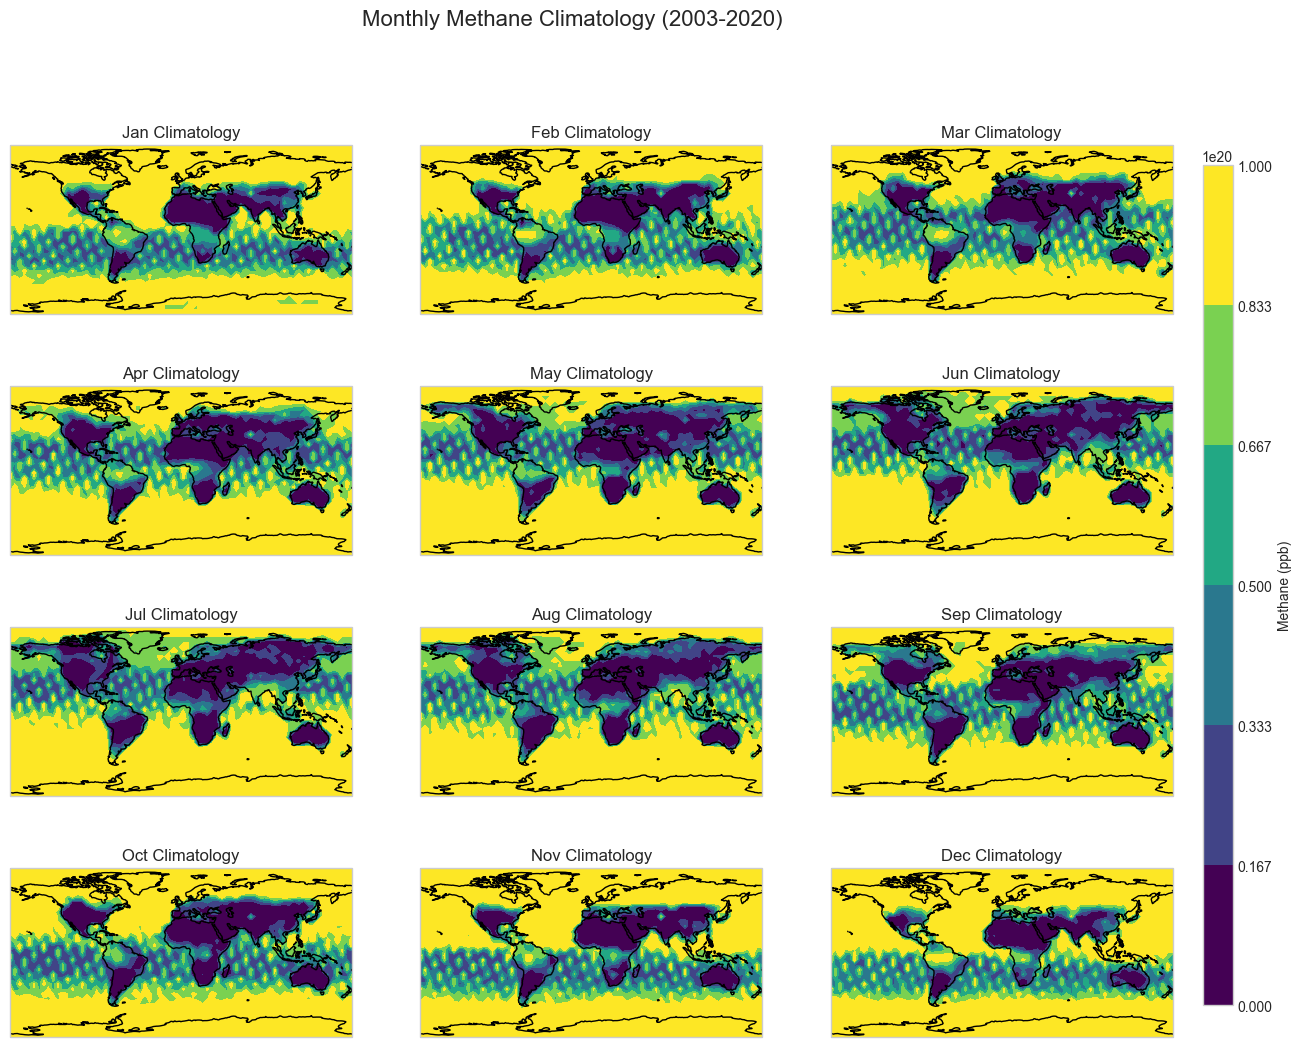

In [2]:
# === 1.1 计算月气候态 ===
# 使用 groupby 对 'time.month' 进行分组并求平均
# xch4 是数据里的变量名（题目里说了）
clim_month = ds['xch4'].groupby('time.month').mean(dim='time')

# === 开始画图 ===
# 创建一个 4行 x 3列 的画布，每个子图都是 PlateCarree 投影
fig, axes = plt.subplots(4, 3, figsize=(15, 12),
                         subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

# 定义月份名称，方便加标题
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# 设定统一的 colorbar 范围，这样不同月份之间好对比
# 我先大概看了一下数据的最大最小值
vmin = clim_month.min().item()
vmax = clim_month.max().item()

for i, ax in enumerate(axes):
    # 提取当前月份的数据
    month_data = clim_month.isel(month=i)

    # 画图
    # add_coastlines() 给地图加海岸线
    ax.add_feature(cfeature.COASTLINE)

    # 绘制等值填充图
    im = month_data.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                                  cmap='viridis', # 选个颜色
                                  vmin=vmin, vmax=vmax,
                                  add_colorbar=False) # 先不加每个图的colorbar，最后加一个大的

    ax.set_title(f'{month_names[i]} Climatology')

# 给整个图加一个共用的 colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # 位置调整一下
fig.colorbar(im, cax=cbar_ax, label='Methane (ppb)')

plt.suptitle('Monthly Methane Climatology (2003-2020)', fontsize=16)
plt.show()

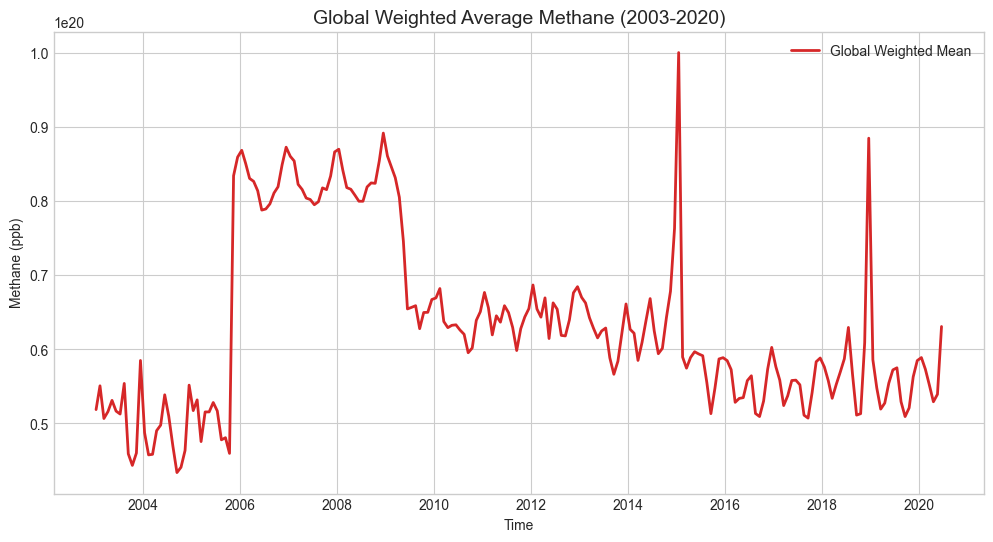

In [5]:
# === 1.2 全球平均时间序列 (修正版) ===
# 第一步：先对经度 (lon) 求普通平均
# 因为同一纬度圈上，每个网格的面积宽度是一样的，所以经度方向不需要加权
zonally_averaged = ds['xch4'].mean(dim='lon')

# 第二步：计算纬度权重
weights = np.cos(np.deg2rad(ds.lat))
weights.name = "weights"

# 第三步：对纬度 (lat) 进行加权平均
# 注意：这时候 zonally_averaged 已经没有 lon 维度了，所以只对 lat 求平均
global_mean = zonally_averaged.weighted(weights).mean(dim='lat')

# === 画图 ===
plt.figure(figsize=(12, 6))
global_mean.plot(color='tab:red', linewidth=2, label='Global Weighted Mean')

plt.title('Global Weighted Average Methane (2003-2020)', fontsize=14)
plt.ylabel('Methane (ppb)')
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.show()

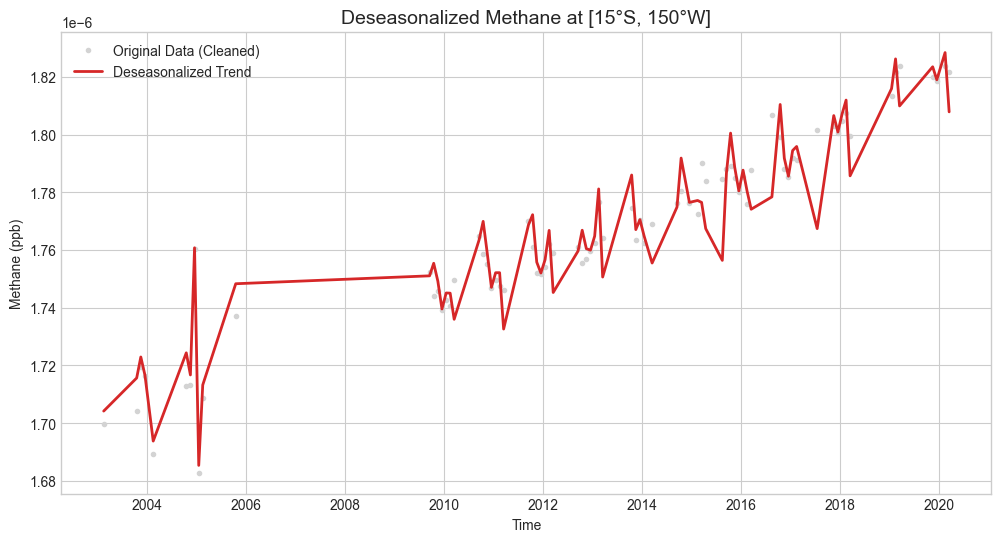

In [17]:
# === 1.3 特定点去季节化时间序列 ===
# 读取数据
file_path = '200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc'
ds = xr.open_dataset(file_path)

# === 关键修正步骤：手动清洗数据 ===
# 甲烷浓度通常在 1600-2000 ppb 左右。
# 如果数据里有 1e20 这种巨大的数，说明是无效值。
# 我们用 .where() 只要小于 5000 的数据，其他的让它变成 NaN
ds_clean = ds.where(ds['xch4'] < 5000)

# === 1.3 特定点去季节化时间序列 (最终修正版) ===

# 1. 选取特定点 [15°S, 150°W]
# 注意：一定要用清洗过的数据 ds_clean
point_data = ds_clean['xch4'].sel(lat=-15, lon=-150, method='nearest')

# 2. 再次检查：去掉全是空值的时间点（drop=True 会把 NaN 的时间点扔掉）
point_data = point_data.dropna(dim='time')

# 3. 计算该点的“长期平均值”
long_term_mean = point_data.mean()

# 4. 计算“月气候态” (12个数值)
monthly_climatology = point_data.groupby('time.month').mean()

# 5. 算出“纯季节性因子” (Seasonal Cycle)
# 也就是：每个月相对于总体平均值偏高或偏低多少
seasonal_cycle = monthly_climatology - long_term_mean

# 6. 去季节化 (Deseasonalized)
# 核心公式：原始数据 - 季节性波动
# 这里的 groupby 会自动把 1月的因子减去 1月的数据，2月减2月...
deseasonalized = point_data.groupby('time.month') - seasonal_cycle

# === 画图 ===
plt.figure(figsize=(12, 6))

# 画原始数据 (灰色点，作为背景对比)
plt.plot(point_data.time, point_data, 'o', color='lightgray',
         markersize=3, label='Original Data (Cleaned)')

# 画去季节后的数据 (红线)
plt.plot(deseasonalized.time, deseasonalized, color='tab:red',
         linewidth=2, label='Deseasonalized Trend')

plt.title('Deseasonalized Methane at [15°S, 150°W]', fontsize=14)
plt.ylabel('Methane (ppb)')
plt.xlabel('Time')
plt.legend()
plt.grid(True)

plt.show()

In [12]:
# Question_2.1
import xarray as xr
import matplotlib.pyplot as plt

ds = xr.open_dataset(r"E:\ESE5023\NOAA_NCDC_ERSST_v3b_SST.nc")
print(ds)

<xarray.Dataset> Size: 44MB
Dimensions:  (lat: 89, lon: 180, time: 684)
Coordinates:
  * lat      (lat) float32 356B -88.0 -86.0 -84.0 -82.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 5kB 1960-01-01 1960-01-01 ... 1960-01-01
Data variables:
    sst      (time, lat, lon) float32 44MB ...
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...


In [13]:
print(ds["lon"].min().item(), ds["lon"].max().item())

0.0 358.0


In [14]:
sst = ds["sst"]
sst = sst.where((sst < 100) & (sst > -5))
lon_min, lon_max = 190, 240
nino34_region = sst.sel(
    lat=slice(-5, 5),
    lon=slice(lon_min, lon_max)
)
nino34_ts = nino34_region.mean(dim=["lat", "lon"], skipna=True)
print(nino34_ts.shape)

(684,)


In [15]:
# 计算月气候态：对不同月份分组，在 time 上求平均
nino34_clim = nino34_ts.groupby("time.month").mean("time", skipna=True)

# 计算异常：每个时间点减去对应月份的平均
nino34_anom = nino34_ts.groupby("time.month") - nino34_clim

print(nino34_clim.shape)
print(nino34_anom.shape)
print(nino34_clim)
print(nino34_anom)

(1,)
(684,)
<xarray.DataArray 'sst' (month: 1)> Size: 4B
array([11.260505], dtype=float32)
Coordinates:
  * month    (month) int64 8B 1
<xarray.DataArray 'sst' (time: 684)> Size: 3kB
array([ 14.988034 ,  15.013577 ,  15.711249 ,  16.246555 ,  16.357422 ,
        15.979873 ,  15.796798 ,  15.578734 ,  15.325479 ,  15.077146 ,
        15.0722685,  15.144248 ,  15.116141 ,  15.3478155,  15.739026 ,
        16.248398 ,  16.586933 ,  16.576946 ,  15.868428 ,  15.145383 ,
        14.69938  ,  14.664626 ,  14.93687  ,  14.935634 ,  14.862832 ,
        15.026158 ,  15.543368 ,  15.966596 ,  15.970487 ,  15.910678 ,
        15.662042 ,  15.246865 ,  14.804536 ,  14.790893 ,  14.615455 ,
        14.487458 ,  14.606214 ,  15.12506  ,  16.049026 ,  16.606922 ,
        16.444347 ,  16.414478 ,  16.626408 ,  16.359337 ,  16.190674 ,
        16.29126  ,  16.341702 ,  16.438831 ,  16.159168 ,  16.005497 ,
        15.848861 ,  15.799159 ,  15.673036 ,  15.391618 ,  15.154592 ,
        14.469731 ,  14.2

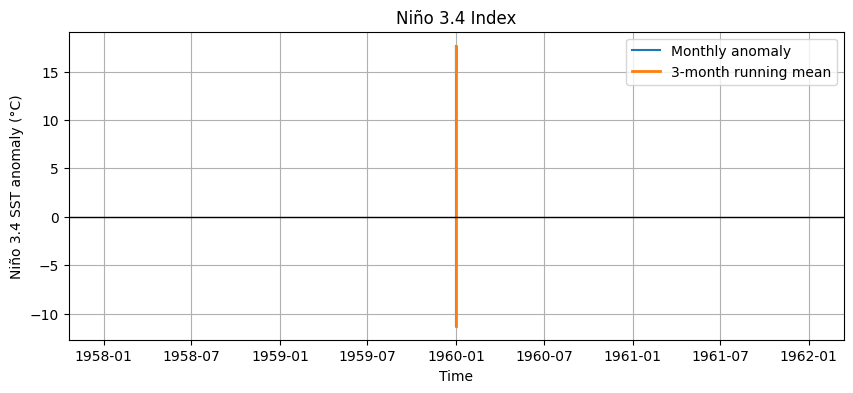

In [16]:
# Question_2.2
nino34_anom_3m = nino34_anom.rolling(time=3, center=True).mean()
time = ds["time"]

plt.figure(figsize=(10, 4))
plt.plot(time, nino34_anom, label="Monthly anomaly")
plt.plot(time, nino34_anom_3m, linewidth=2, label="3-month running mean")
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Time")
plt.ylabel("Ni\u00f1o 3.4 SST anomaly (°C)")
plt.title("Ni\u00f1o 3.4 Index")
plt.grid(True)
plt.legend()
plt.show()